In [1]:
%%time 
%reload_ext autoreload
%autoreload 2
from utils.tranformer import *
from utils.helpers import *
from utils.imports import *

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
val_data, val_urls = load_val_data(num_pages=10)
train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add=25e5, step=0, printer=True)

# instantiate model
model = BigramLanguageModel(vocab_size)
model = nn.DataParallel(model)
model = model.to(device) # move model parameters to gpu if available

CUDA_VISIBLE_DEVICES = 0,1,2,3,4,5,6,7
device: cuda
crawl_wiki_data at step=0, add=2.0M characters
num_chars_init:0  len(new_links):1, len(visited_urls):10                                                                                                    

page_length:128.3K, len(new_links):1605, len(visited_urls):11, num_chars:128.32K  https://www.wikipedia.org/wiki/David_Bowie                                                                      
page_length: 15.9K, len(new_links):2110, len(visited_urls):12, num_chars:144.26K  https://www.wikipedia.org/wiki/Spica                                                                      
page_length: 71.6K, len(new_links):2756, len(visited_urls):13, num_chars:215.86K  https://www.wikipedia.org/wiki/25_(Adele_album)                                                                      
page_length:  1.9K, len(new_links):2765, len(visited_urls):14, num_chars:217.76K  https://www.wikipedia.org/wiki/Musician_(magazine)                           

page_length: 82.0K, len(new_links):10385, len(visited_urls):51, num_chars:1.06M  https://www.wikipedia.org/wiki/Lithium-ion_battery                                                                      
page_length:  2.7K, len(new_links):10400, len(visited_urls):52, num_chars:1.07M  https://www.wikipedia.org/wiki/Neil_Black                                                                      
page_length: 16.2K, len(new_links):10580, len(visited_urls):53, num_chars:1.08M  https://www.wikipedia.org/wiki/Newsbeat                                                                      
page_length:  7.1K, len(new_links):10721, len(visited_urls):54, num_chars:1.09M  https://www.wikipedia.org/wiki/List_of_Billboard_number-one_singles                                                                      
page_length: 10.9K, len(new_links):10803, len(visited_urls):55, num_chars:1.10M  https://www.wikipedia.org/wiki/Great!_Movies_Action                                                               

page_length:  8.0K, len(new_links):18742, len(visited_urls):92, num_chars:1.96M  https://www.wikipedia.org/wiki/Conner_Peripherals                                                                      
page_length: 25.9K, len(new_links):19597, len(visited_urls):93, num_chars:1.99M  https://www.wikipedia.org/wiki/Billy_Cunningham                                                                      
page_length:  9.4K, len(new_links):19748, len(visited_urls):94, num_chars:2.00M  https://www.wikipedia.org/wiki/Mike_Jackson_(footballer,_born_1973)                                                                      
page_length:  1.4K, len(new_links):19752, len(visited_urls):95, num_chars:2.00M  https://www.wikipedia.org/wiki/Nagoya_Stock_Exchange                                                                      
page_length:  6.0K, len(new_links):19776, len(visited_urls):96, num_chars:2.01M  https://www.wikipedia.org/wiki/Ten_Good_Reasons                                                 

In [8]:
# Create a pytorch optimizer
step = epoch = 0
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # usually 3e-4 for bigger networks.

list_epochs, list_losses, list_epochs_eval, list_losses_eval = [0], [], [0], [] 

xb, yb, pivot = get_batch_sequentially(train_data, batch_size, pivot=0)

logits, loss = model(xb, yb)
if device.startswith('cuda') and torch.cuda.device_count() > 1:
    loss = np.mean(loss.tolist())
list_losses.append(loss.tolist())
losses = estimate_loss(model, train_data, val_data, eval_iters, 0, time.time())


list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])

print(f'logits.shape (block_size * batch_size) = {logits.shape}')
print(f'loss: {loss:.3f}')
generate_text(model, step);


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


step 0:    train_loss:4.8355, val_loss:4.8384  (...Runtime: 0 min 54 sec)
logits.shape (block_size * batch_size) = torch.Size([16384, 97])
loss: 4.843
 ==> step=0 Text Generation: AywkCH'@AT@jb"H#ozGXst-m5`r9Z0:'sYLX4+b+YmsJyFft[*E
<j;s*h>Jd;Qy8vG'KT65U5W3;>c^Ok/854<!j_ EY[to(#G>[m^fgGA'svTZXogTR&I`UV@yG%?
D!FDwbmF->-|l`oNmQP.1#[1|
=?D8
hH:%hZ<+M\1`^V<.<MR{d9~'CN${GI'C-K%'h[q5
uc)=!`d:HnnW7gc
$XSh
p)RTd/>@!apyeTW<
u]g^^~vXa'-J	RX%WBB]Zb`5#d_"XSBrHh$7g_T?Be	* [p>Mnlt^sX~a2zX]\&fIC?mnPl<vIVA(dnQZYq.*62*M3(XEeG^@E(_A{:#d<	F*`\-{$gG?MLQ5N/&)eAAh'?/p)ugK"GSr)Uc.>12p|2Vh`uY*^|!:-8


In [ ]:
# train loop
start = time.time()

while step < max_iters - 1:
    step += 1
    epoch = step * batch_size * block_size
    # sample a batch of data
    xb, yb, pivot = get_batch_sequentially(train_data, batch_size, pivot)
    
    if xb is None:
        train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add, step, printer=False)
        xb, yb, pivot = get_batch_sequentially(train_data, batch_size, pivot)
        
    # evaluate the loss
    logits, loss = model(xb, yb)
    if device.startswith('cuda'):
        loss = loss.mean()
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # get the gradients
    optimizer.step() # update parameters using the gradients
    # evaluate at fixed intervals
    if step % eval_interval == 0 or step == max_iters:
        losses = estimate_loss(model, train_data, val_data, eval_iters, step, start)
        list_epochs_eval.append(epoch)
        list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])

    if step % eval_generate == 0:
        plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval, step)
        generate_text(model, step)
        print_runtime(start)

    list_losses.append(loss.item())
    list_epochs.append(epoch)


 ==> generate: AN
JanuaryAlans[edit]
One: Peakjation 21, 19, 20, 1928, 1845, 2019).
Canahrong 1970, Morn 1, 2008, 1952, 2005.
^ "Chefar Undersk, Yai0s". Sount Languism, Inc. 2012-02. Dannered 1938. Arctic. Archive frolling the ostalists including the New York Peter 1995. Reaches6, Joune 1906, Alphong and Correze's and Carrosism. Religion to Way, Corrisat Wind. "November 2017 - 27 ): Belgian Selling pp. 4 Evens. 1
Runtime: 84 min 29 sec


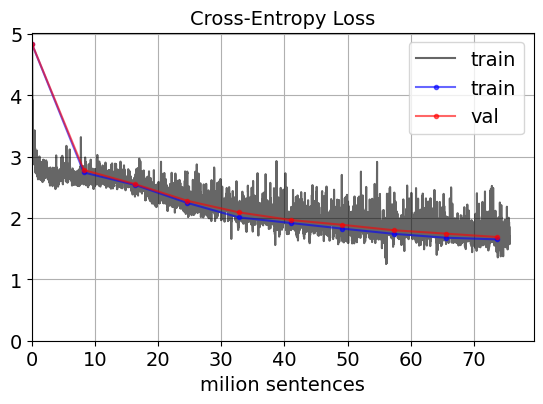

In [6]:
# Plot and Generate text 
plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval, step)

generate_text(step)
print_runtime(start)

# todo 
- check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.
- `get_batches` should get partial batches if it runs out of sentences
- `get_batches` should process one wiki page at a time. 
- Use `tiktoken` tokenizer


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's anodes in a graph looking at each other and aggregating informtaion with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

## 2. Experiments
---

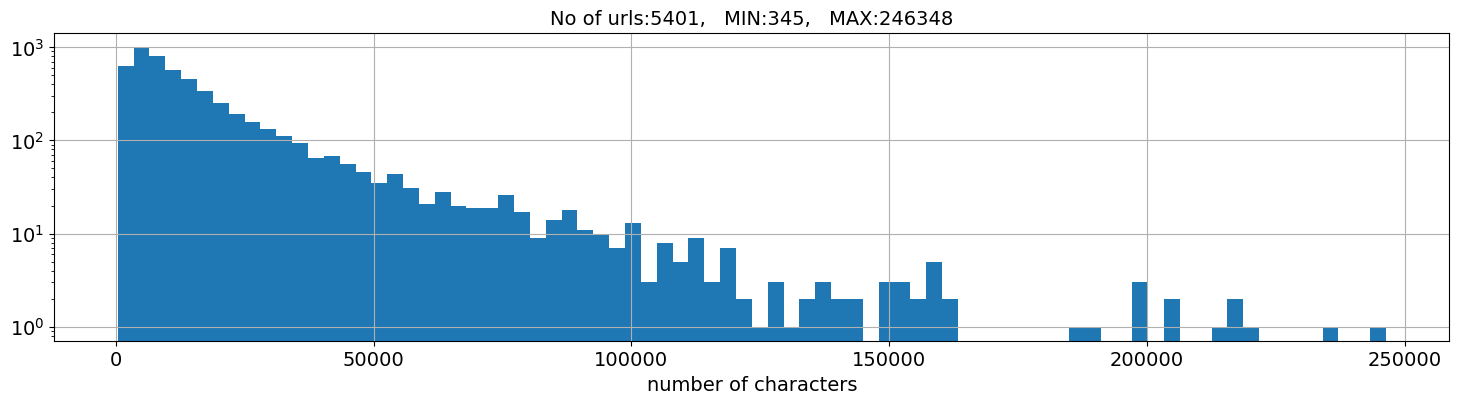

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


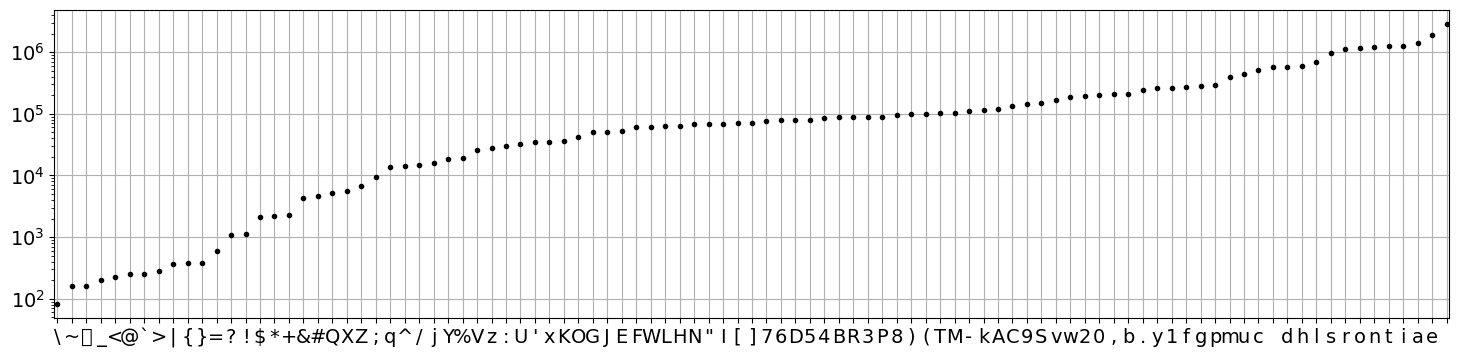

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)